In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


Date
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
2021-02-22    126.000000
2021-02-23    125.860001
Name: Close, dtype: float64

Series([], Name: Close, dtype: float64)


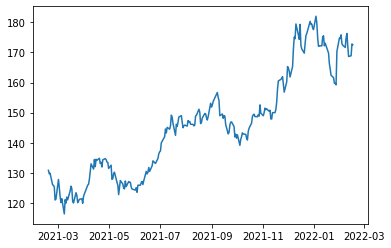

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
print(ts[ts.isna()]) # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 
plt.plot(ts)

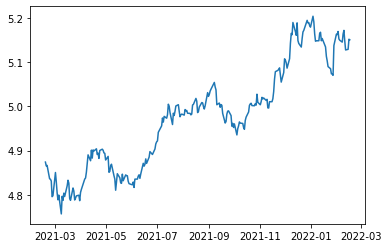

In [4]:

# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

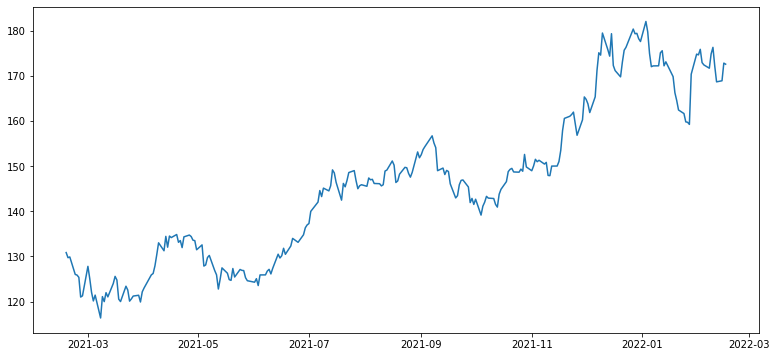

In [5]:
# 정성적 분석
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


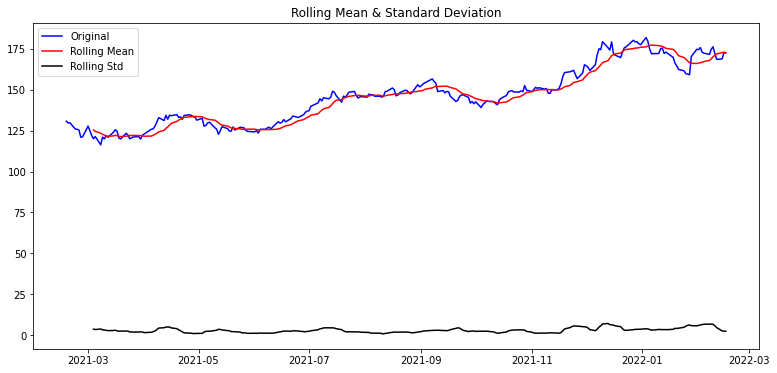

In [7]:
plot_rolling_statistics(ts, window=12)

In [8]:
# 안전성 확인하기
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [9]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -0.655953
p-value                          0.857831
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


p-value 가 안정적이지 않다고 판단된다. 1에 가깝기 떄문이다.
그래서 어떻게 하면 안정적으로 만들 수 있을까??
- 로그 함수 변환
- 시계열 분해


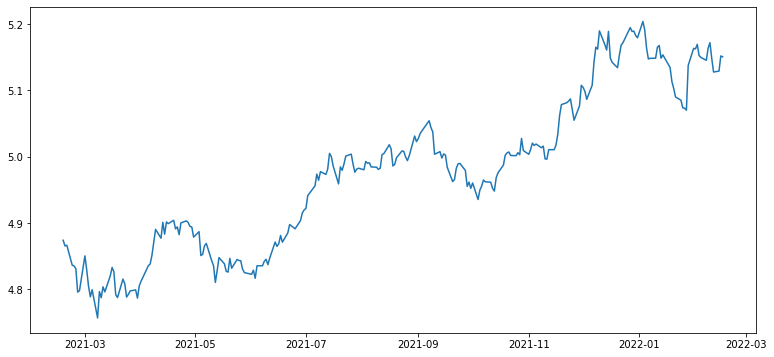

In [10]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [11]:
augmented_dickey_fuller_test(ts_log)
#value값이 줄어들었음을 확인 할 수있다

Results of Dickey-Fuller Test:
Test Statistic                  -0.690251
p-value                          0.849259
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


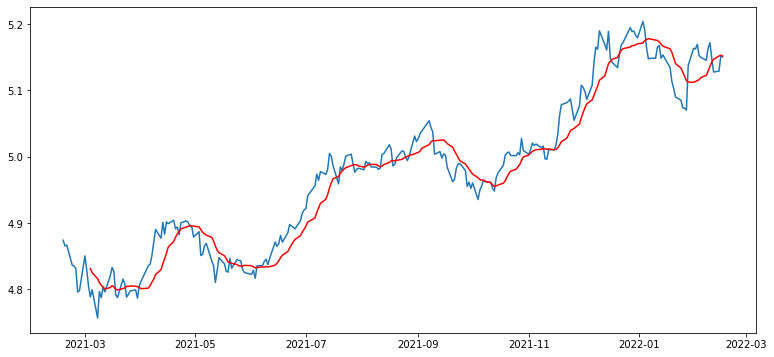

In [12]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [13]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26         NaN
2021-03-01         NaN
2021-03-02         NaN
2021-03-03         NaN
2021-03-04   -0.042656
2021-03-05   -0.025748
2021-03-08   -0.059264
2021-03-09   -0.013585
Name: Close, dtype: float64

In [14]:
# 결측치 제거해주기
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-03-04   -0.042656
2021-03-05   -0.025748
2021-03-08   -0.059264
2021-03-09   -0.013585
2021-03-10   -0.018715
2021-03-11    0.000276
2021-03-12   -0.004456
2021-03-15    0.017666
2021-03-16    0.027418
2021-03-17    0.022946
2021-03-18   -0.008433
2021-03-19   -0.011498
2021-03-22    0.014213
2021-03-23    0.006535
2021-03-24   -0.016290
Name: Close, dtype: float64

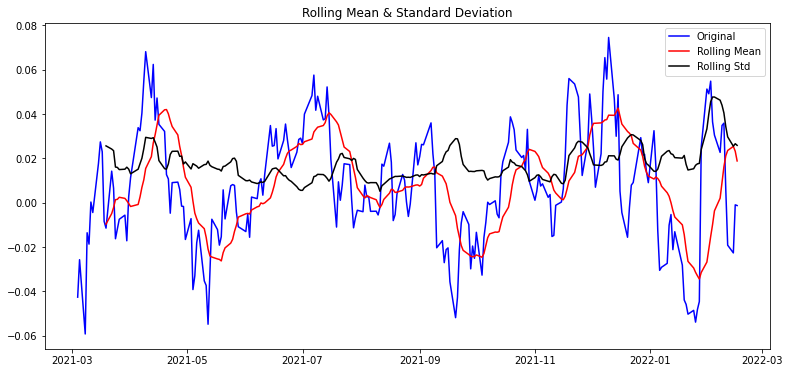

In [15]:
plot_rolling_statistics(ts_log_moving_avg)

In [16]:
augmented_dickey_fuller_test(ts_log_moving_avg)
#0.6 값에 비해 굉장히 많이 떨어졌다

Results of Dickey-Fuller Test:
Test Statistic                  -4.583698
p-value                          0.000138
#Lags Used                       1.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


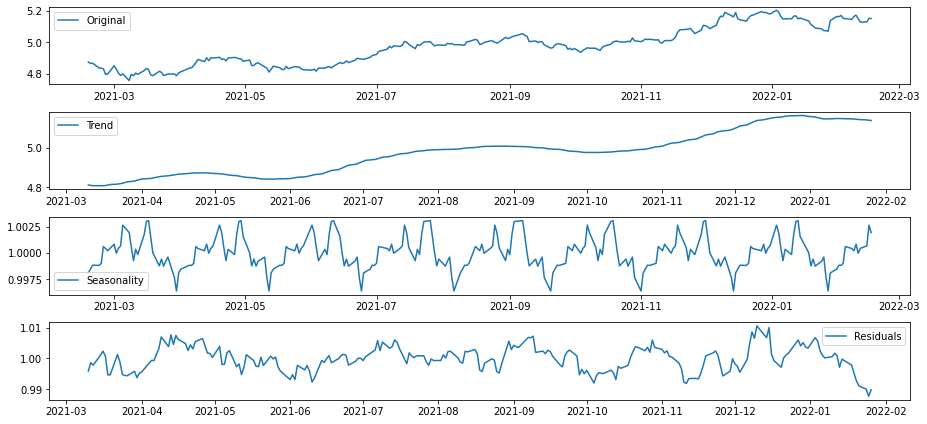

In [17]:
# 시계열 분해하기

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [18]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.449081
p-value                          0.000243
#Lags Used                       6.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


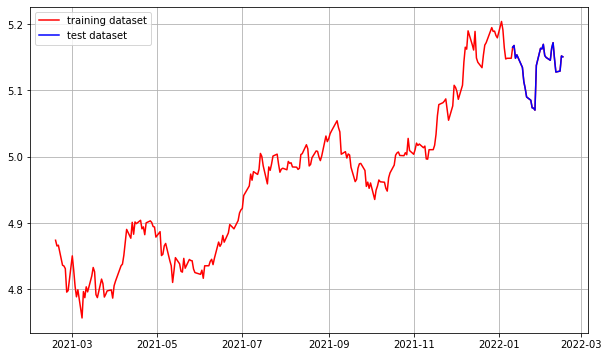

In [19]:
# 학습 테스트 데이터 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


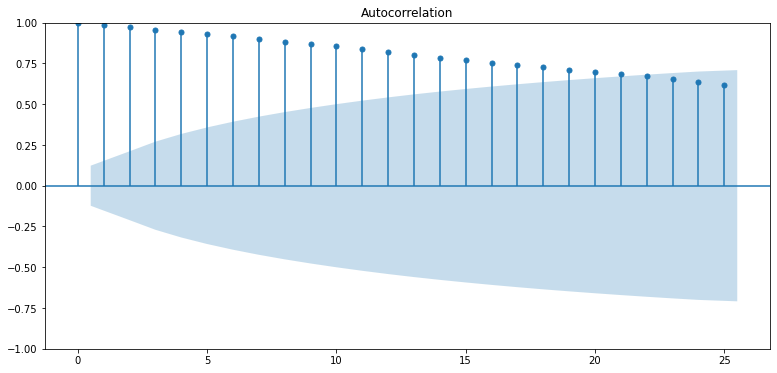

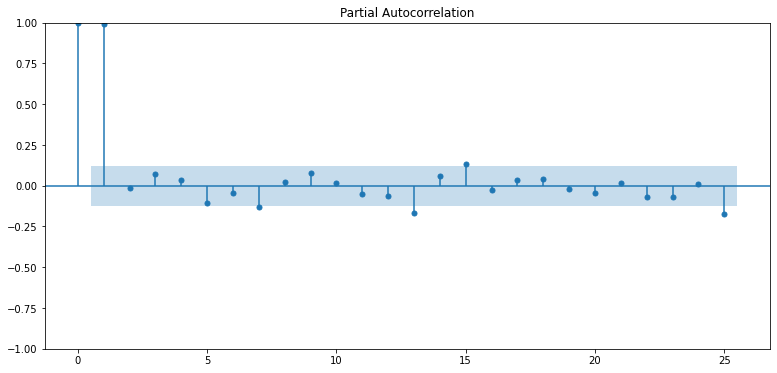

Results of Dickey-Fuller Test:
Test Statistic                -1.613159e+01
p-value                        4.778989e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.700936e+00
p-value                        1.339935e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


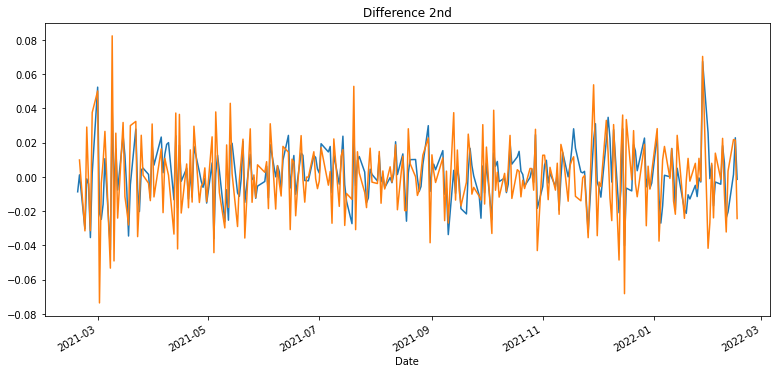

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 629.132
Date:                Thu, 17 Feb 2022   AIC                          -1248.263
Time:                        12:30:06   BIC                          -1231.117
Sample:                             0   HQIC                         -1241.345
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9556      0.368     13.454      0.000       4.234       5.678
ar.L1          1.4366      0.666      2.157      0.031       0.131       2.742
ar.L2         -0.4378      0.664     -0.659      0.5

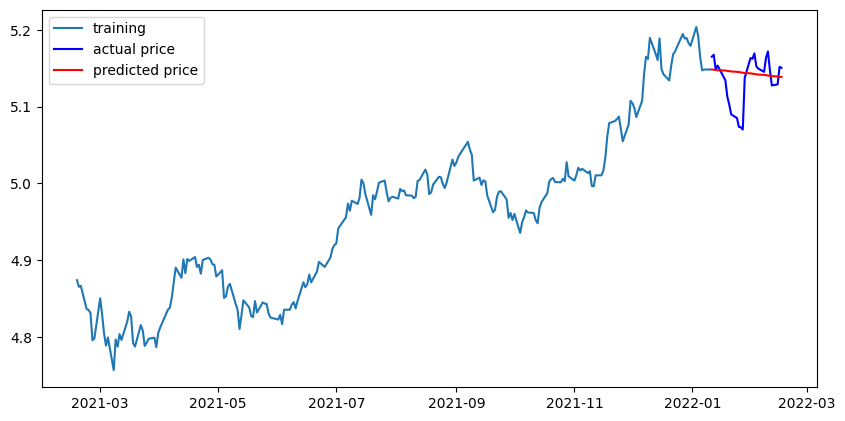

In [21]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  32.45152747631074
MAE:  4.344695480989407
RMSE:  5.696624217579279
MAPE: 2.62%
